# Hypothesis Testing on PLA2 Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os

import sys 
sys.path.append('../vespag')

from parse.vep_scores import load_vespag_scores_from_folder
from src.plotting import *
from src.amino_acid_groups import AA_GROUPS
from src.constants import GEMME_ALPHABET
from src.utils import *

## Load Scores

In [3]:
# load all the vespag scores for the pla2 dataset 
vespag_folder = '/mnt/f/nicole/pla2_vespag'
vespag_scores = load_vespag_scores_from_folder(vespag_folder)   
vespag_scores['wildtype'] = vespag_scores['residue'].str[0]
vespag_scores['mutant'] = vespag_scores['mutation'].str[-1]
# normalise the vespag score into [0,1]
vespag_scores['mutation_effect'] = - vespag_scores['vespag']
vespag_scores['mutation_effect'] = (vespag_scores['mutation_effect'] - vespag_scores['mutation_effect'].min()) / (vespag_scores['mutation_effect'].max() - vespag_scores['mutation_effect'].min())
vespag_scores['mutation_type'] = vespag_scores['wildtype'] + '-' + vespag_scores['mutant']
vespag_scores.head()

Loading VespaG scores: 100%|██████████| 524/524 [00:05<00:00, 89.78file/s] 


,residue,mutation,vespag,id,wildtype,mutant,mutation_effect,mutation_type
0,N1,N1A,-2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,A,0.364656,N-A
1,N1,N1Y,-3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,Y,0.493063,N-Y
2,N1,N1W,-4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,W,0.530656,N-W
3,N1,N1V,-3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,V,0.471612,N-V
4,N1,N1T,-2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,T,0.343762,N-T


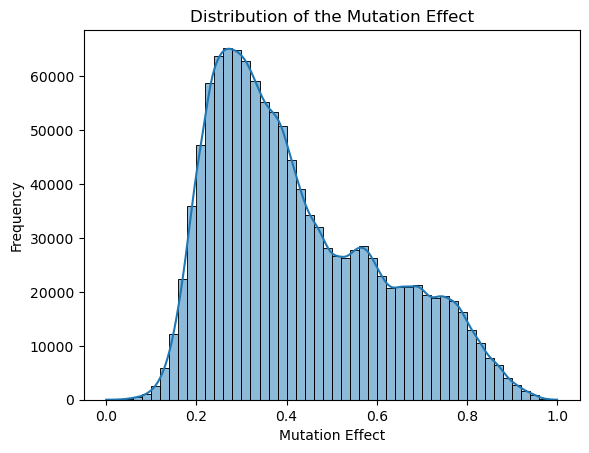

In [4]:
# check the distributiuon of the mutation effect 
sns.histplot(vespag_scores['mutation_effect'], bins=50, kde=True)
plt.title('Distribution of the Mutation Effect')
plt.xlabel('Mutation Effect')
plt.ylabel('Frequency')
plt.show()

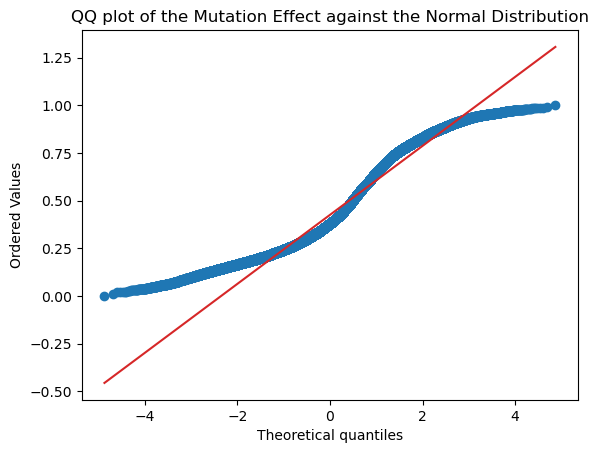

In [5]:
from scipy import stats

# Q-Q plot against the normal distribution
fig, ax = plt.subplots()
res = stats.probplot(vespag_scores['mutation_effect'], dist="norm", plot=ax)

ax.get_lines()[0].set_color("tab:blue")
ax.get_lines()[1].set_color("tab:red")

ax.set_title('QQ plot of the Mutation Effect against the Normal Distribution')
plt.show()


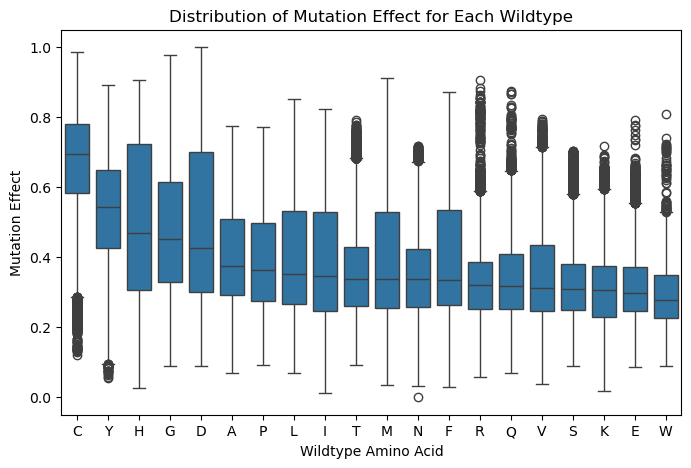

In [6]:
# show the distribution of the mutation effect for each amino acid
plt.figure(figsize=(8,5))
# order by the median of the mutation effect
order = vespag_scores.groupby('wildtype')['mutation_effect'].median().sort_values(ascending=False).index
sns.boxplot(data=vespag_scores, x='wildtype', y='mutation_effect', order=order)
plt.title('Distribution of Mutation Effect for Each Wildtype')
plt.xlabel('Wildtype Amino Acid')
plt.ylabel('Mutation Effect')
plt.show()

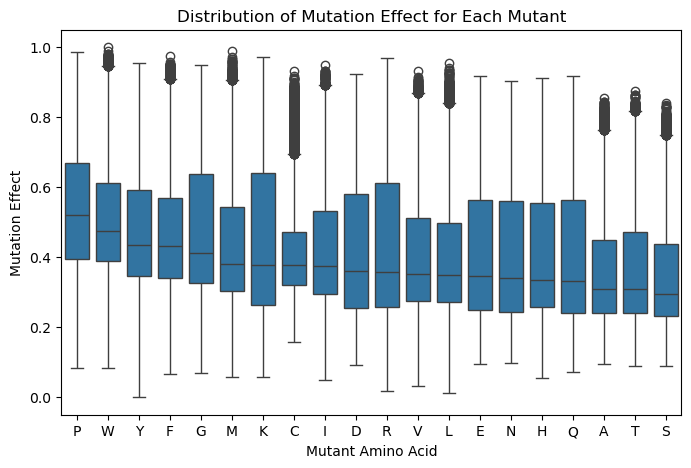

In [7]:
# show the distribution of the mutation effect for each amino acid
plt.figure(figsize=(8,5))
# order by the median of the mutation effect
order = vespag_scores.groupby('mutant')['mutation_effect'].median().sort_values(ascending=False).index
sns.boxplot(data=vespag_scores, x='mutant', y='mutation_effect', order=order)
plt.title('Distribution of Mutation Effect for Each Mutant')
plt.xlabel('Mutant Amino Acid')
plt.ylabel('Mutation Effect')
plt.show()

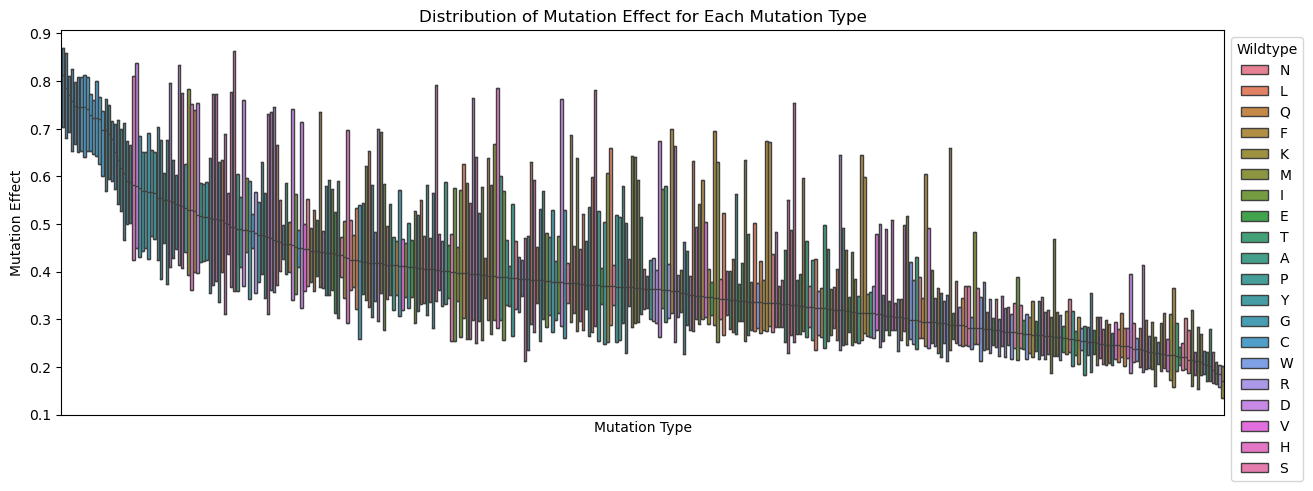

In [9]:
# show the distribution of the mutation effect for each amino acid
plt.figure(figsize=(15,5))
# order by the median of the mutation effect
order = vespag_scores.groupby('mutation_type')['mutation_effect'].median().sort_values(ascending=False).index
sns.boxplot(data=vespag_scores, x='mutation_type', y='mutation_effect', order=order, hue='wildtype', showfliers=False, whis=0)
plt.title('Distribution of Mutation Effect for Each Mutation Type')
plt.xlabel('Mutation Type')
plt.xticks([])
plt.ylabel('Mutation Effect')
plt.legend(title="Wildtype", bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## Does the wildtype influence the VespaG scores more than the mutation does?

### Kruskal Wallis Test 

- Non-parametric extension of ANOVA 
- H0: The median of the mutation effect does not depend on the wildtype / The meidan of the mutation effect is the same for all wildtype amino acids. 

In [41]:
from scipy.stats import kruskal 
from scipy.stats import chi2 

def custom_kruskal_wallis_test(df, alpha, feature, target):
    # get the unique values of the feature
    unique_values = df[feature].unique()
    # group the target based on the unique values of the feature
    groups = [df[df[feature] == value][target] for value in unique_values]
    # perform the kruskal wallis test
    stat, p = kruskal(*groups)
    degrees_of_freedom = len(groups) - 1
    critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)
    significance = p < alpha
    return stat, p, critical_value, degrees_of_freedom, significance

In [11]:
alpha = 0.001

stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'wildtype', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Wildype vs. Mutation Effect: p={p}, stat={stat}, critical_value={critical_value}, degrees_of_freedom={degrees_of_freedom}, significance={significance}')
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'mutant', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Mutant vs. Mutation Effect: p={p}, stat={stat}, critical_value={critical_value}, degrees_of_freedom={degrees_of_freedom}, significance={significance}')

Kruskal-Wallis Test for the Wildype vs. Mutation Effect: p=0.0, stat=386704.1512957871, critical_value=43.82019596451753, degrees_of_freedom=19, significance=True
Kruskal-Wallis Test for the Mutant vs. Mutation Effect: p=0.0, stat=91183.19038029629, critical_value=43.82019596451753, degrees_of_freedom=19, significance=True


### Dunn's Test 

- Pairwise test after Kruskal Wallis Test 
- H0: The median of the mutation effect does not depend on the wildtype / The meidan of the mutation effect is the same for all wildtype amino acids. 

In [12]:
from statsmodels.stats.multitest import multipletests

def custom_dunns_test(df, alpha, feature, target):
    ''' We have to prevent MemoryError that results from the internal implementation of the posthoc_dunn function
    
    Computes only a single Kruskal-Wallis test at a time instead of constructing an NxN matrix.
    Bonferroni correction is applied to the p-values.
    '''
    # we have to split the dataset into different groups for performance reasons 
    groups = df[feature].unique()
    posthoc_results = []
    for group1 in groups:
        for group2 in groups:
            if group1 < group2:  # Avoid redundant comparisons
                group1_data = df[df[feature] == group1][target].values
                group2_data = df[df[feature] == group2][target].values
                
                # Only run test if both groups have enough data
                _, p_value = kruskal(group1_data, group2_data)
                
                posthoc_results.append({
                    'group_1': group1,
                    'group_2': group2,
                    'p_value': p_value
                })
    
    # correct for multiple comparisons using bonferroni
    posthoc_results = pd.DataFrame(posthoc_results)
    _, p_adjusted, _, _ = multipletests(posthoc_results['p_value'], method='bonferroni')
    posthoc_results['p_adjusted'] = p_adjusted
    posthoc_results['significant'] = posthoc_results['p_adjusted'] < alpha
    return posthoc_results

In [13]:
# for each pair of amino acids, perform the dunn's test
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'wildtype', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
12,L,P,0.021520,1.000000,False
22,Q,V,0.010845,1.000000,False
25,F,L,0.033799,1.000000,False
31,F,P,0.000277,0.052670,False
63,I,M,0.909788,1.000000,False
165,D,G,0.000083,0.015797,False


In [14]:
# for each pair of amino acids, perform the dunn's test
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'mutant', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
3,A,T,0.394886,1.000000,False
63,K,M,0.000055,0.010439,False
79,D,V,0.002242,0.426061,False
104,E,L,0.436210,1.000000,False
106,E,H,0.969012,1.000000,False
123,F,G,0.247489,1.000000,False
132,C,M,0.150804,1.000000,False
153,H,L,0.000566,0.107569,False
187,N,Q,0.000348,0.066073,False


### Fligner-Killeen Test

- For non normal data 
- H0: The variance of the groups is the same. 

In [15]:
from scipy.stats import fligner

def custon_fligner_killeen_test(df, alpha, feature, target):
    groups = df[feature].unique()
    group_data = [df[df[feature] == group][target].values for group in groups]
    stat, p = fligner(*group_data)
    significance = p < alpha
    return stat, p, significance    

In [16]:
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'wildtype', 'mutation_effect')
print(f'Fligner-Killeen Test for the Wildype vs. Mutation Effect: p={p}, stat={stat}, significance={significance}')
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'mutant', 'mutation_effect')
print(f'Fligner-Killeen Test for the Mutant vs. Mutation Effect: p={p}, stat={stat}, significance={significance}')

Fligner-Killeen Test for the Wildype vs. Mutation Effect: p=0.0, stat=145717.73474535398, significance=True
Fligner-Killeen Test for the Mutant vs. Mutation Effect: p=0.0, stat=39684.586423121844, significance=True


### Pairwise Fligner-Killeen Test with Bonferroni Correction

- Post hoc analysis of Fligner-Killeen test

In [17]:
def custom_fligner_killeen_post_hoc_test(df, alpha, feature, target):
    groups = df[feature].unique()
    posthoc_results = []
    for group1 in groups:
        for group2 in groups:
            if group1 < group2:
                group1_data = df[df[feature] == group1][target].values
                group2_data = df[df[feature] == group2][target].values
                _, p = fligner(group1_data, group2_data)
                posthoc_results.append({
                    'group_1': group1,
                    'group_2': group2,
                    'p_value': p,
                })
    # correct for multiple comparisons using bonferroni
    posthoc_results = pd.DataFrame(posthoc_results)
    _, p_adjusted, _, _ = multipletests(posthoc_results['p_value'], method='bonferroni')
    posthoc_results['p_adjusted'] = p_adjusted
    posthoc_results['significant'] = posthoc_results['p_adjusted'] < alpha
    return posthoc_results

In [18]:
# for each pair of amino acids, perform the fligner-killeen test
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'wildtype', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
28,F,M,0.007120,1.000000,False
29,F,I,0.000196,0.037278,False
98,A,T,0.972789,1.000000,False
99,A,P,0.010386,1.000000,False
102,A,C,0.023065,1.000000,False
110,P,T,0.000086,0.016381,False
138,C,T,0.188105,1.000000,False
139,C,P,0.000457,0.086870,False
169,D,H,0.000111,0.021032,False


In [19]:
# for each pair of amino acids, perform the fligner-killeen test
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'mutant', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
4,A,S,0.007706,1.000000,False
20,V,Y,0.029587,1.000000,False
42,M,Y,0.001410,0.267821,False
69,L,V,0.196001,1.000000,False
82,D,Q,0.000009,0.001736,False
88,D,E,0.000794,0.150913,False
93,D,N,0.057756,1.000000,False
109,E,N,0.154627,1.000000,False
110,F,Y,0.018317,1.000000,False
112,F,V,0.000970,0.184268,False


### Mutual Information 

How dependent is the mutational effect on the wildtype or the mutant?

#### Data Enrichtment: Add amino acid properties

In [20]:
from parse.getarea import get_getarea_data_from_folder

In [21]:
getarea_path = '/mnt/f/nicole/pla2_getarea'

getarea_df = get_getarea_data_from_folder(getarea_path)
getarea_df.head()

,residue,residue_number,total,apolar,backbone,sidechain,ratio,in_out,id
0,H1,1.0,12.62,5.83,0.09,12.52,8.1,i,AB072173_1_Protobothrops_flavoviridis
1,L2,2.0,79.70,77.11,3.05,76.65,52.4,o,AB072173_1_Protobothrops_flavoviridis
2,L3,3.0,103.26,102.91,0.55,102.71,70.3,o,AB072173_1_Protobothrops_flavoviridis
3,Q4,4.0,18.59,6.64,0.00,18.59,12.9,i,AB072173_1_Protobothrops_flavoviridis
4,F5,5.0,22.07,22.07,0.00,22.07,12.3,i,AB072173_1_Protobothrops_flavoviridis


In [22]:
vespag_scores = vespag_scores.merge(getarea_df.drop(['residue_number'], axis=1), on=['id', 'residue'])
vespag_scores.head()

,residue,mutation,vespag,id,wildtype,mutant,mutation_effect,mutation_type,total,apolar,backbone,sidechain,ratio,in_out
0,N1,N1A,-2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,A,0.364656,N-A,21.94,4.76,0.33,21.62,18.9,i
1,N1,N1Y,-3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,Y,0.493063,N-Y,21.94,4.76,0.33,21.62,18.9,i
2,N1,N1W,-4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,W,0.530656,N-W,21.94,4.76,0.33,21.62,18.9,i
3,N1,N1V,-3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,V,0.471612,N-V,21.94,4.76,0.33,21.62,18.9,i
4,N1,N1T,-2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,T,0.343762,N-T,21.94,4.76,0.33,21.62,18.9,i


In [24]:
from src.amino_acid_groups import AA_GROUPS, BIOCHEMICAL_CLASSIFICATION, CHARGE_POLARITY_CLASSIFICATION

In [25]:
# add the biochemical classification to the dataset
vespag_scores['wildtype_biochemical'] = vespag_scores['wildtype'].map(BIOCHEMICAL_CLASSIFICATION)
vespag_scores['mutant_biochemical'] = vespag_scores['mutant'].map(BIOCHEMICAL_CLASSIFICATION)
vespag_scores['biochemical_change'] = vespag_scores['wildtype_biochemical'] != vespag_scores['mutant_biochemical']

# add the charge polarity classification to the dataset
vespag_scores['wildtype_charge_polarity'] = vespag_scores['wildtype'].map(CHARGE_POLARITY_CLASSIFICATION)
vespag_scores['mutant_charge_polarity'] = vespag_scores['mutant'].map(CHARGE_POLARITY_CLASSIFICATION)
vespag_scores['charge_polarity_change'] = vespag_scores['wildtype_charge_polarity'] != vespag_scores['mutant_charge_polarity']

vespag_scores.head()

,residue,mutation,vespag,id,wildtype,mutant,mutation_effect,mutation_type,total,apolar,backbone,sidechain,ratio,in_out,wildtype_biochemical,mutant_biochemical,biochemical_change,wildtype_charge_polarity,mutant_charge_polarity,charge_polarity_change
0,N1,N1A,-2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,A,0.364656,N-A,21.94,4.76,0.33,21.62,18.9,i,polar_uncharged,hydrophobic,True,polar,non_polar,True
1,N1,N1Y,-3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,Y,0.493063,N-Y,21.94,4.76,0.33,21.62,18.9,i,polar_uncharged,hydrophobic,True,polar,polar,False
2,N1,N1W,-4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,W,0.530656,N-W,21.94,4.76,0.33,21.62,18.9,i,polar_uncharged,hydrophobic,True,polar,non_polar,True
3,N1,N1V,-3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,V,0.471612,N-V,21.94,4.76,0.33,21.62,18.9,i,polar_uncharged,hydrophobic,True,polar,non_polar,True
4,N1,N1T,-2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,T,0.343762,N-T,21.94,4.76,0.33,21.62,18.9,i,polar_uncharged,polar_uncharged,False,polar,polar,False


In [26]:
# add the complex amino acid properties as well 
complex_aa_groups = AA_GROUPS.keys()
for group in complex_aa_groups:
    vespag_scores[f'wildtype_{group}'] = vespag_scores['wildtype'].apply(lambda x: AA_GROUPS[group][x])
    vespag_scores[f'mutant_{group}'] = vespag_scores['mutant'].apply(lambda x: AA_GROUPS[group][x])
    vespag_scores[f'{group}_change'] = vespag_scores[f'wildtype_{group}'] != vespag_scores[f'mutant_{group}']
vespag_scores.head()

,residue,mutation,vespag,id,wildtype,mutant,mutation_effect,mutation_type,total,apolar,...,physicochemical_classes_change,wildtype_charge_classes,mutant_charge_classes,charge_classes_change,wildtype_polarity_classes,mutant_polarity_classes,polarity_classes_change,wildtype_hydrogen_donor_acceptor_classes,mutant_hydrogen_donor_acceptor_classes,hydrogen_donor_acceptor_classes_change
0,N1,N1A,-2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,A,0.364656,N-A,21.94,4.76,...,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,none,True
1,N1,N1Y,-3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,Y,0.493063,N-Y,21.94,4.76,...,True,uncharged,uncharged,False,polar,polar,False,donor and acceptor,donor and acceptor,False
2,N1,N1W,-4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,W,0.530656,N-W,21.94,4.76,...,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,donor,True
3,N1,N1V,-3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,V,0.471612,N-V,21.94,4.76,...,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,none,True
4,N1,N1T,-2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,T,0.343762,N-T,21.94,4.76,...,True,uncharged,uncharged,False,polar,polar,False,donor and acceptor,donor and acceptor,False


Kruskal-Wallis Test 

In [28]:
# kruskal wallis test for the biochemical classification
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'wildtype_biochemical', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Wildype Biochemical vs. Mutation Effect: p={p}, significance={significance}')
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'mutant_biochemical', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Mutant Biochemical vs. Mutation Effect: p={p}, significance={significance}')
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'biochemical_change', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Biochemical Change vs. Mutation Effect: p={p}, significance={significance}')

Kruskal-Wallis Test for the Wildype Biochemical vs. Mutation Effect: p=0.0, significance=True
Kruskal-Wallis Test for the Mutant Biochemical vs. Mutation Effect: p=0.0, significance=True
Kruskal-Wallis Test for the Biochemical Change vs. Mutation Effect: p=0.0, significance=True


In [29]:
# kruskal wallis test for the charge polarity classification
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'wildtype_charge_polarity', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Wildype Charge Polarity vs. Mutation Effect: p={p}, significance={significance}')
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'mutant_charge_polarity', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Mutant Charge Polarity vs. Mutation Effect: p={p}, significance={significance}')
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'charge_polarity_change', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Charge Polarity Change vs. Mutation Effect: p={p}, significance={significance}')

Kruskal-Wallis Test for the Wildype Charge Polarity vs. Mutation Effect: p=0.0, significance=True
Kruskal-Wallis Test for the Mutant Charge Polarity vs. Mutation Effect: p=0.0, significance=True
Kruskal-Wallis Test for the Charge Polarity Change vs. Mutation Effect: p=0.0, significance=True


In [40]:
stats, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores[~ pd.isna(vespag_scores['in_out'])], alpha, 'in_out', 'mutation_effect')
print(f'Kruskal-Wallis Test for the In/Out vs. Mutation Effect: p={p}, significance={significance}')

Feature: in_out, Unique Values: ['i' 'o']
Kruskal-Wallis Test for the In/Out vs. Mutation Effect: p=0.0, significance=True


Dunns Test

In [42]:
# for each pair of amino acids, perform the dunn's test
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'wildtype_biochemical', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
9,negative_charged,proline,0.545851,1.0,False


In [43]:
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'mutant_biochemical', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [44]:
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'biochemical_change', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [45]:
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'wildtype_charge_polarity', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [46]:
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'mutant_charge_polarity', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [47]:
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'charge_polarity_change', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


Fligner-Killeen Test 

In [48]:
# fligner killeen test for the biochemical classification
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'wildtype_biochemical', 'mutation_effect')
print(f'Fligner-Killeen Test for the Wildype Biochemical vs. Mutation Effect: p={p}, significance={significance}')
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'mutant_biochemical', 'mutation_effect')
print(f'Fligner-Killeen Test for the Mutant Biochemical vs. Mutation Effect: p={p}, significance={significance}')
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'biochemical_change', 'mutation_effect')
print(f'Fligner-Killeen Test for the Biochemical Change vs. Mutation Effect: p={p}, significance={significance}')

Fligner-Killeen Test for the Wildype Biochemical vs. Mutation Effect: p=0.0, significance=True
Fligner-Killeen Test for the Mutant Biochemical vs. Mutation Effect: p=0.0, significance=True
Fligner-Killeen Test for the Biochemical Change vs. Mutation Effect: p=0.0, significance=True


In [49]:
# fligner killeen test for the charge polarity classification
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'wildtype_charge_polarity', 'mutation_effect')
print(f'Fligner-Killeen Test for the Wildype Charge Polarity vs. Mutation Effect: p={p}, significance={significance}')
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'mutant_charge_polarity', 'mutation_effect')
print(f'Fligner-Killeen Test for the Mutant Charge Polarity vs. Mutation Effect: p={p}, significance={significance}')
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'charge_polarity_change', 'mutation_effect')
print(f'Fligner-Killeen Test for the Charge Polarity Change vs. Mutation Effect: p={p}, significance={significance}')

Fligner-Killeen Test for the Wildype Charge Polarity vs. Mutation Effect: p=0.0, significance=True
Fligner-Killeen Test for the Mutant Charge Polarity vs. Mutation Effect: p=0.0, significance=True
Fligner-Killeen Test for the Charge Polarity Change vs. Mutation Effect: p=0.0, significance=True


In [50]:
# post hoc fligner killeen test for the biochemical classification
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'wildtype_biochemical', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
19,cysteine,proline,0.000457,0.009601,False


In [51]:
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'mutant_biochemical', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
18,glycine,proline,0.025915,0.544214,False


In [52]:
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'biochemical_change', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [53]:
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'wildtype_charge_polarity', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [54]:
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'mutant_charge_polarity', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [55]:
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'charge_polarity_change', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


### Mutual Information on the Enriched Data

In [56]:
vespag_scores.columns

Index(['residue', 'mutation', 'vespag', 'id', 'wildtype', 'mutant',
       'mutation_effect', 'mutation_type', 'total', 'apolar', 'backbone',
       'sidechain', 'ratio', 'in_out', 'wildtype_biochemical',
       'mutant_biochemical', 'biochemical_change', 'wildtype_charge_polarity',
       'mutant_charge_polarity', 'charge_polarity_change',
       'wildtype_hydropathy_classes', 'mutant_hydropathy_classes',
       'hydropathy_classes_change', 'wildtype_volume_classes',
       'mutant_volume_classes', 'volume_classes_change',
       'wildtype_chemical_classes', 'mutant_chemical_classes',
       'chemical_classes_change', 'wildtype_physicochemical_classes',
       'mutant_physicochemical_classes', 'physicochemical_classes_change',
       'wildtype_charge_classes', 'mutant_charge_classes',
       'charge_classes_change', 'wildtype_polarity_classes',
       'mutant_polarity_classes', 'polarity_classes_change',
       'wildtype_hydrogen_donor_acceptor_classes',
       'mutant_hydrogen_donor_

In [57]:
features = ['wildtype', 'mutant', 'mutation_type', 'total', 'apolar', 'backbone',
       'sidechain', 'ratio', 'in_out', 'wildtype_biochemical',
       'mutant_biochemical', 'biochemical_change', 'wildtype_charge_polarity',
       'mutant_charge_polarity', 'charge_polarity_change',
       'wildtype_hydropathy_classes', 'mutant_hydropathy_classes',
       'hydropathy_classes_change', 'wildtype_volume_classes',
       'mutant_volume_classes', 'volume_classes_change',
       'wildtype_chemical_classes', 'mutant_chemical_classes',
       'chemical_classes_change', 'wildtype_physicochemical_classes',
       'mutant_physicochemical_classes', 'physicochemical_classes_change',
       'wildtype_charge_classes', 'mutant_charge_classes',
       'charge_classes_change', 'wildtype_polarity_classes',
       'mutant_polarity_classes', 'polarity_classes_change',
       'wildtype_hydrogen_donor_acceptor_classes',
       'mutant_hydrogen_donor_acceptor_classes',
       'hydrogen_donor_acceptor_classes_change']

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def custom_mutual_info_regression(df, feature, target):
    try:
        df[feature].astype(float, errors='raise')
        
    except:
        # if we do not have a numerical feature, we balance the df wrt. the values in the feature
        min_count = df[feature].value_counts().min()
        df_balanced = df.groupby(feature).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
    feature = df_balanced[feature]
    feature_encoded = feature.astype('category').cat.codes
    mutual_information = mutual_info_regression(feature_encoded.values.reshape(-1, 1), df_balanced[target], discrete_features=True)
    return mutual_information

In [61]:
# for each feature, compute the mutual information with the mutation effect
# store the results in a dataframe 
mutual_information = []
for feature in tqdm(features, desc='Mutual Information'):
    mi = custom_mutual_info_regression(vespag_scores, feature, 'mutation_effect')
    mutual_information.append({
        'feature': feature,
        'mutual_information': mi[0]
    })
mutual_information = pd.DataFrame(mutual_information)
mutual_information.head()

Mutual Information: 100%|██████████| 36/36 [10:58<00:00, 18.31s/it]


,feature,mutual_information
0,wildtype,0.273920
1,mutant,0.103717
2,mutation_type,0.677968
3,total,0.421132
4,apolar,0.365224


In [62]:
mutual_information = mutual_information.sort_values(by='mutual_information', ascending=False)

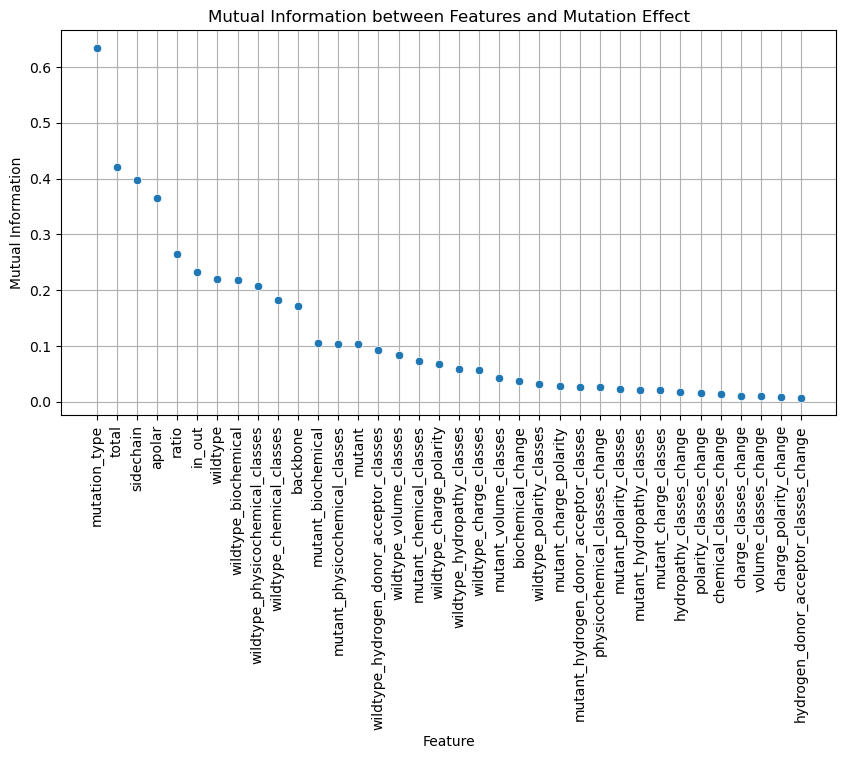

In [66]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=mutual_information, x='feature', y='mutual_information', zorder=2)
plt.title('Mutual Information between Features and Mutation Effect')
plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.xticks(rotation=90)
plt.grid(zorder=0)
plt.show()

In [69]:
vespag_scores.columns

Index(['residue', 'mutation', 'vespag', 'id', 'wildtype', 'mutant',
       'mutation_effect', 'mutation_type', 'total', 'apolar', 'backbone',
       'sidechain', 'ratio', 'in_out', 'wildtype_biochemical',
       'mutant_biochemical', 'biochemical_change', 'wildtype_charge_polarity',
       'mutant_charge_polarity', 'charge_polarity_change',
       'wildtype_hydropathy_classes', 'mutant_hydropathy_classes',
       'hydropathy_classes_change', 'wildtype_volume_classes',
       'mutant_volume_classes', 'volume_classes_change',
       'wildtype_chemical_classes', 'mutant_chemical_classes',
       'chemical_classes_change', 'wildtype_physicochemical_classes',
       'mutant_physicochemical_classes', 'physicochemical_classes_change',
       'wildtype_charge_classes', 'mutant_charge_classes',
       'charge_classes_change', 'wildtype_polarity_classes',
       'mutant_polarity_classes', 'polarity_classes_change',
       'wildtype_hydrogen_donor_acceptor_classes',
       'mutant_hydrogen_donor_

In [77]:
vespag_scores.head()

,residue,mutation,vespag,id,wildtype,mutant,mutation_effect,mutation_type,total,apolar,backbone,sidechain,ratio,in_out,wildtype_biochemical,mutant_biochemical,biochemical_change,wildtype_charge_polarity,mutant_charge_polarity,charge_polarity_change,wildtype_hydropathy_classes,mutant_hydropathy_classes,hydropathy_classes_change,wildtype_volume_classes,mutant_volume_classes,volume_classes_change,wildtype_chemical_classes,mutant_chemical_classes,chemical_classes_change,wildtype_physicochemical_classes,mutant_physicochemical_classes,physicochemical_classes_change,wildtype_charge_classes,mutant_charge_classes,charge_classes_change,wildtype_polarity_classes,mutant_polarity_classes,polarity_classes_change,wildtype_hydrogen_donor_acceptor_classes,mutant_hydrogen_donor_acceptor_classes,hydrogen_donor_acceptor_classes_change
0,N1,N1A,-2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,A,0.364656,N-A,21.94,4.76,0.33,21.62,18.9,i,polar_uncharged,hydrophobic,True,polar,non_polar,True,hydrophilic,hydrophobic,True,small,very small,True,amide,aliphatic,True,amide,aliphatic,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,none,True
1,N1,N1Y,-3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,Y,0.493063,N-Y,21.94,4.76,0.33,21.62,18.9,i,polar_uncharged,hydrophobic,True,polar,polar,False,hydrophilic,neutral,True,small,very large,True,amide,aromatic,True,amide,Y,True,uncharged,uncharged,False,polar,polar,False,donor and acceptor,donor and acceptor,False
2,N1,N1W,-4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,W,0.530656,N-W,21.94,4.76,0.33,21.62,18.9,i,polar_uncharged,hydrophobic,True,polar,non_polar,True,hydrophilic,hydrophobic,True,small,very large,True,amide,aromatic,True,amide,W,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,donor,True
3,N1,N1V,-3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,V,0.471612,N-V,21.94,4.76,0.33,21.62,18.9,i,polar_uncharged,hydrophobic,True,polar,non_polar,True,hydrophilic,hydrophobic,True,small,medium,True,amide,aliphatic,True,amide,aliphatic,True,uncharged,uncharged,False,polar,nonpolar,True,donor and acceptor,none,True
4,N1,N1T,-2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus,N,T,0.343762,N-T,21.94,4.76,0.33,21.62,18.9,i,polar_uncharged,polar_uncharged,False,polar,polar,False,hydrophilic,neutral,True,small,small,False,amide,hydroxyl,True,amide,hydroxyl,True,uncharged,uncharged,False,polar,polar,False,donor and acceptor,donor and acceptor,False


In [78]:
vespag_scores['residue_index_zero_based'] = vespag_scores['residue'].str[1:].astype(int) - 1

In [88]:
annotation_data = ['id', 'residue_index_zero_based', 'wildtype', 'total', 'apolar', 'backbone',
       'sidechain', 'ratio', 'in_out', 'wildtype_biochemical', 'wildtype_charge_polarity',
       'wildtype_hydropathy_classes', 'wildtype_volume_classes',
       'wildtype_chemical_classes', 'wildtype_physicochemical_classes',
       'wildtype_charge_classes', 'wildtype_polarity_classes',
       'wildtype_hydrogen_donor_acceptor_classes']

annotation_df = vespag_scores[annotation_data].drop_duplicates()

# for columns that are floats
for col in ['total', 'apolar', 'backbone', 'sidechain', 'ratio']:
       # normalize the values into [0,1], and then round to the first decimal
       annotation_df[col] = (annotation_df[col] - annotation_df[col].min()) / (annotation_df[col].max() - annotation_df[col].min())
       annotation_df[col] = annotation_df[col].round(1)

annotation_df.to_csv('/mnt/f/nicole/pla2_residue_annotation.csv', sep='\t', index=False)

In [89]:
annotation_df.query("id == 'YNZC_BACSU'")

,id,residue_index_zero_based,wildtype,total,apolar,backbone,sidechain,ratio,in_out,wildtype_biochemical,wildtype_charge_polarity,wildtype_hydropathy_classes,wildtype_volume_classes,wildtype_chemical_classes,wildtype_physicochemical_classes,wildtype_charge_classes,wildtype_polarity_classes,wildtype_hydrogen_donor_acceptor_classes
